<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/COVID19-PPE-Object-Detection-yolov5/Kaggle_COVID_19_PPE_Dataset_Train_(yolo_v5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID-19 Personal Protective Equipment (PPE) Detection Dataset for Our COVID-19 Warriors

https://www.kaggle.com/ialimustufa/object-detection-for-ppe-covid19-dataset


* 5 Classes(Mask, Face Sheild, Full Cover, Gloves, Goggles)

* 367 Train Images
* 50 Test Images

#1. Ultralytics Yolov5 설치

In [1]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 10901, done.
remote: Total 10901 (delta 0), reused 0 (delta 0), pack-reused 10901
Receiving objects: 100% (10901/10901), 11.04 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (7524/7524), done.
/content/yolov5
     |████████████████████████████████| 596 kB 12.9 MB/s 
/content


#2. 데이터 다운로드

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [3]:
!kaggle datasets download -d ialimustufa/object-detection-for-ppe-covid19-dataset

 98% 121M/123M [00:02<00:00, 38.7MB/s]
100% 123M/123M [00:02<00:00, 51.3MB/s]


In [ ]:
!unzip '*.zip'

In [5]:
!mkdir covid
!mkdir covid/images; mkdir covid/labels
!mkdir covid/images/train; mkdir covid/images/val
!mkdir covid/labels/train; mkdir covid/labels/val

# 3. 데이터 셋의 annotation을 Ultralytics Yolo format으로 생성
* annotation용 xml 파일을 txt 파일로 변환
* 하나의 이미지는 하나의 txt 파일로 변환
* 확장자를 제외한 이미지의 파일명과 annotation 파일명이 서로 동일해야 함.
* 하나의 xml annotation 파일을 Yolo 포맷용 txt 파일로 변환하는 함수 생성
* voc annotation의 좌상단(Top left: x1, y1), 우하단(Bottom right: x2, y2) 좌표를 Bounding Box 중심 좌표(Center_x, Center_y)와 너비(width), 높이(height)로 변경
* 중심 좌표와 너비, 높이는 원본 이미지 레벨로 scale 되어야 함. 모든 값은 0~1 사이 값으로 변환됨.
* class_id는 여러개의 label들을 0 부터 순차적으로 1씩 증가시켜 id 부여

In [6]:
!cat /content/dataset/train/21fdf.xml

<annotation>
	<folder>ppe hd</folder>
	<filename>21fdf.jpg</filename>
	<path>E:\ppe hd\21fdf.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>3600</width>
		<height>2025</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>Goggles</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1520</xmin>
			<ymin>614</ymin>
			<xmax>2327</xmax>
			<ymax>969</ymax>
		</bndbox>
	</object>
	<object>
		<name>Mask</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1579</xmin>
			<ymin>902</ymin>
			<xmax>2184</xmax>
			<ymax>1283</ymax>
		</bndbox>
	</object>
	<object>
		<name>Face_Shield</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1406</xmin>
			<ymin>345</ymin>
			<xmax>2386</xmax>
			<ymax>1633</ymax>
		</bndbox>
	</object>
	<object>
		<name>Gloves</name>
		<pose>Uns

In [7]:
import glob
import xml.etree.ElementTree as ET
import cv2
CLASS_NAMES = []

sample_img = '/content/dataset/train/5uhyf.jpg'
sample_annot = '/content/dataset/train/5uhyf.xml'

tree = ET.parse(sample_annot)
root = tree.getroot()

## 샘플 데이터 바운딩 박스 시각화

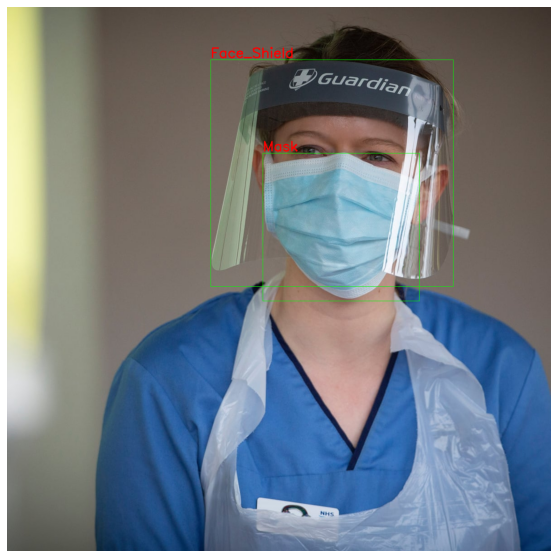

In [8]:
import matplotlib.pyplot as plt
img = cv2.imread(sample_img)
img_copy = img.copy()
img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

for obj in root.findall('object'):

  bbox = obj.find('bndbox')
  x1 = int(bbox.find('xmin').text)
  y1 = int(bbox.find('ymin').text)
  x2 = int(bbox.find('xmax').text)
  y2 = int(bbox.find('ymax').text)
  class_name = obj.find('name').text

  cv2.rectangle(img_rgb, (x1,y1), (x2,y2), color = (0, 255, 0), thickness = 1)
  cv2.putText(img_rgb, class_name, (x1, y1 - 5),fontFace = cv2.FONT_HERSHEY_SIMPLEX ,fontScale = 1, color = (255, 0, 0), thickness = 2)

plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(img_rgb);


In [9]:
def xml_to_txt(input_xml_file, output_txt_file):
  # ElementTree로 입력 XML파일 파싱
  tree = ET.parse(input_xml_file)
  root = tree.getroot()
  img_node = root.find('size')
  # 만약 img_node를 찾지 못하면 해당 xml파일을 변환 종료
  if img_node is None:
    return None

  # 원본 이미지의 너비와 높이 추출.
  img_width = int(img_node.find('width').text)
  img_height = int(img_node.find('height').text)

  # 만약 너비와 높이 값이 0이라면 이미지 파일을 읽어서 너비와 높이를 구함
  if img_width == 0 or img_height == 0:
    img_path = input_xml_file.replace('.xml', '.jpg')
    if cv2.imread(img_path) is None:
      img_height, img_width = cv2.imread(img_path.replace('.jpg', '.png')).shape[:2]
    else:
      img_height, img_width = cv2.imread(img_path).shape[:2]
  
  # xml 파일내에 있는 모든 object Element를 찾는다.
  with open(output_txt_file, 'w') as output_fpointer:
    for obj in root.findall('object'):
      # bndbox를 찾아서 좌상단(x1, y1), 우하단(x2, y2) 좌표 추출.
      xmlbox = obj.find('bndbox')
      x1 = int(xmlbox.find('xmin').text)
      y1 = int(xmlbox.find('ymin').text)
      x2 = int(xmlbox.find('xmax').text)
      y2 = int(xmlbox.find('ymax').text)

      object_name = obj.find('name').text

      # 만약 좌표중에 0보다 작은 값이 있으면 해당 xml파일 변환 종료
      if (x1 < 0) or (y1 < 0) or (x2 < 0) or (y2 < 0):
        break
      
      # object_name 원본 좌표를 입력하여 Yolo 포맷으로 변환하는 함수 호출
      class_id, cx_norm, cy_norm, bbw_norm, bbh_norm = convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2)

      #변환된 yolo 좌표를 object별로 출력 text 파일에 write
      value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, bbw_norm, bbh_norm)
      output_fpointer.write(value_str + '\n')

def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출.
  if object_name not in CLASS_NAMES:
    CLASS_NAMES.append(object_name)
  class_id = CLASS_NAMES.index(object_name)
  # 중심 좌표와 너비, 높이 계산. 
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1
  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

샘플 annotation 파일 포맷 변환

In [10]:
xml_to_txt(sample_annot, 'covid/labels/train/' + sample_annot.split('/')[-1].replace('.xml', '.txt'))

In [11]:
!cat /content/covid/labels/train/5uhyf.txt

0 0.61375 0.4041667 0.2875 0.2716667
1 0.5970833 0.305 0.4458333 0.4166667


In [12]:
import shutil

def make_yolo_annot_file(src_dir, dst_dir):
  src_imgs = glob.glob(src_dir + '/*.jpg')
  src_imgs.extend(glob.glob(src_dir + '/*.png'))
  src_imgs.extend(glob.glob(src_dir + '/*.jpeg'))
  src_annots = glob.glob(src_dir + '/*.xml')

  if 'train' in src_dir:
    dst_img_dir = os.path.join(dst_dir, 'images/train')
    dst_annot_dir = dst_img_dir.replace('images', 'labels')
  else:
    dst_img_dir = os.path.join(dst_dir, 'images/val')
    dst_annot_dir = dst_img_dir.replace('images', 'labels')

  for img in src_imgs:
    shutil.copy(img, os.path.join(dst_img_dir,img.split('/')[-1]))
  
  for annot in src_annots:
    xml_to_txt(annot, os.path.join(dst_annot_dir, annot.split('/')[-1].replace('.xml', '.txt')))

# train용 images와 label annotation 생성
make_yolo_annot_file('/content/dataset/train', '/content/covid')
# validation용 images와 label annotation 생성
make_yolo_annot_file('/content/dataset/test', '/content/covid')

In [13]:
print(len(glob.glob('/content/covid/images/train/*')))
print(len(glob.glob('/content/covid/images/val/*')))
print(len(glob.glob('/content/covid/labels/train/*')))
print(len(glob.glob('/content/covid/labels/val/*')))

367
50
367
50


In [14]:
print(CLASS_NAMES)

['Mask', 'Face_Shield', 'Coverall', 'Gloves', 'Goggles']


#4. COVID-19 PPE Dataset 학습 수행

In [15]:
#train log와 weights를 저장할 경로 생성
!mkdir /content/drive/MyDrive/covidPPE

mkdir: cannot create directory ‘/content/drive/MyDrive/covidPPE’: File exists


In [17]:
!python yolov5/train.py --img 1024 --batch 8 --epochs 60 \
--data '/content/covid/covid.yaml' \
--weights yolov5/yolov5s.pt --cache \
--project /content/drive/MyDrive/covidPPE --name chess --exist-ok

train: weights=yolov5/yolov5s.pt, cfg=, data=/content/covid/covid.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=60, batch_size=8, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/covidPPE, name=chess, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-267-g66e5d79 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, h

#5. 학습결과

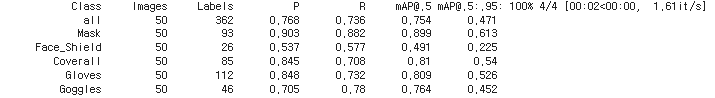

* IoU Threshold가 0.5일때 mAP는 0.75, 0.5 ~ 0.95에서의 mAP평균은 대략 0.47정도가 나온다.
* mAP가 가장 높은 클래스는 0.899로 'Mask'이다.
* mAP가 가장 낮은 클래스는 0.491으로 'Face Shield'이다.